In [288]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [289]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b")

In [290]:
llm.invoke("Hello, I am a student.").content

'Hello! 👋 Nice to meet you. How can I help you today?'

In [291]:
#tavily
from langchain_tavily import TavilySearch
search = TavilySearch()

In [292]:
search.invoke("stock price of bloomberg?")

{'query': 'stock price of bloomberg?',
 'response_time': 1.46,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.investing.com/indices/bbg-energy-tr',
   'title': 'Bloomberg Energy TR Index Today (BCOMENTR)',
   'content': '#### Popular Searches. ##### Please try another search. Find here information about the Bloomberg Energy TR index (BCOMENTR). **What Is the Bloomberg Energy TR Ticker Symbol?**. - May 21, 2025) - SusGlobal Energy Corp. - May 21, 2025) - SusGlobal Energy Corp. S&P 500 Outperformance+2,605.8%. ### What is the Bloomberg Energy TR Ticker Symbol? The current volume for Bloomberg Energy TR is 0. ### What is the 52-week range for Bloomberg Energy TR? The Bloomberg Energy TR stock price has ranged from 61.4143 to 81.0179 over the past 52 weeks. ### From a Technical Analysis Perspective, Is Bloomberg Energy TR a Buy or Sell? **Fusion Media**\xa0and\xa0any provider of the data contained in this website\xa0will not accept liability

In [293]:
code = """
x = 10
y = x + 10
print(y)
"""

In [294]:
from langchain_experimental.utilities import PythonREPL

In [295]:
repl=PythonREPL()

In [296]:
repl.run(code)

'20\n'

In [297]:
from langchain_core.tools import tool
from typing import Annotated

@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\npython\n{code}\nStdout: {result}"
    return result_str

In [298]:
python_repl_tool.invoke(code)

'Successfully executed:\npython\n\nx = 10\ny = x + 10\nprint(y)\n\nStdout: 20\n'

### We hae two sub agents
1. researcher_agent
2. coder_agent

In [299]:
members = ["researcher", "coder"]

In [300]:
options =  members + ["FINISH"]

In [301]:
options

['researcher', 'coder', 'FINISH']

In [302]:
from typing import Literal

In [303]:
from typing_extensions import TypedDict

### There is no routing logic
It is simply going to return the next candidate name


In [304]:
class Router(TypedDict):
    next: Literal["researcher", "coder", "FINISH"]

In [305]:
from langgraph.graph import MessagesState, START, END, StateGraph
#HumanMessage
from langchain_core.messages import HumanMessage

In [306]:
class State(MessagesState):
    next: str

### this is how my state looks like

In [ ]:
state={"messages":["what is square root of 42?"], "next":"researcher"}

In [307]:
system_prompt = f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}.
Given the user request and the conversation so far, decide who should act next.
Respond with exactly one of: researcher, coder, FINISH.
"""

In [308]:
from langgraph.types import Command, Literal

In [309]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my response {'next': 'researcher'}
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
    
    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}
    
    return Command(goto=goto, update={"next":goto})

In [310]:
from langgraph.prebuilt import create_react_agent

In [311]:
def researcher_agent(state: State) -> Command[Literal['supervisor']]:
    research_agent = create_react_agent(llm, tools=[search], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


In [312]:
def coder_agent(state: State) -> Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [313]:
workflow = StateGraph(State)

In [314]:
workflow.add_node('supervisor', supervisor_agent)

In [315]:
workflow.add_node('researcher', researcher_agent)

In [316]:
workflow.add_node('coder', coder_agent)

In [317]:
workflow.add_edge(START, 'supervisor')

In [318]:
app = workflow.compile()

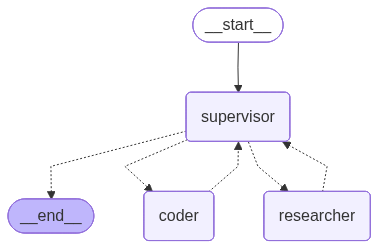

In [319]:
app

In [320]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************


C:\Users\Harikishan\AppData\Local\Temp\ipykernel_3136\1927741006.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(llm, tools=[search], prompt="You are a researcher. DO NOT do any math.")


(('researcher:6a672041-9730-b074-3389-c836de595c5f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "What\'s the square root of 42?" The developer says: "You are a researcher. DO NOT do any math." So we cannot compute the square root directly. We need to respond as a researcher, perhaps providing approximate value from a source, but we cannot do the calculation ourselves. We should search for the square root of 42. Use the search tool to find a reliable source.', 'tool_calls': [{'id': 'fc_50298fff-1813-4450-9077-71949172b91a', 'function': {'arguments': '{"query":"square root of 42","search_depth":"fast","time_range":null,"topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 335, 'total_tokens': 474, 'completion_time': 0.372542529, 'completion_tokens_details': {'reasoning_tokens': 84}, 'prompt_time': 0.004085054, 'prompt_tokens_details': 

In [321]:
for s in app.stream({"messages": [("user", "warite a python code for prime numbers?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


C:\Users\Harikishan\AppData\Local\Temp\ipykernel_3136\2894305030.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")


(('coder:c9958106-54c4-6747-52a0-875619e2a705',), {'agent': {'messages': [AIMessage(content='Here’s a compact, well‑commented Python script that lets you:\n\n1. **Check** whether a single integer is prime (`is_prime` function).  \n2. **Generate** all prime numbers up to a given limit (`primes_up_to` function).  \n3. **Run** a quick demo when the file is executed directly.\n\n```python\n#!/usr/bin/env python3\n"""\nPrime number utilities.\n\n- is_prime(n):   Return True if n is a prime, else False.\n- primes_up_to(limit):  Yield all prime numbers ≤ limit.\n"""\n\nfrom math import isqrt\nfrom typing import Generator, List\n\n\ndef is_prime(n: int) -> bool:\n    """\n    Determine whether n is a prime number.\n\n    Parameters\n    ----------\n    n : int\n        The integer to test. Must be >= 0.\n\n    Returns\n    -------\n    bool\n        True if n is prime, False otherwise.\n    """\n    if n < 2:\n        return False               # 0 and 1 are not prime\n    if n in (2, 3):\n   